# Extended maximum likelihood fit

This notebook represents some domain-specific analysis step that we wish to include in some pipeline.
In particular, we will perform here an extended maximum likelihood fit of the dimuon invariant mass to measure 
the number of $J/\psi$ and $\psi(2S)$ candidates.

In this *stand-alone* notebook, we will obtain the data directly from the OpenData portal, to setup things. 
Another notebook is provided to show how to adapt things to take a file defined from Snakemake as an input.

In [1]:
!pip install iminuit
import numpy as np 
import pickle 
import pandas as pd 
import matplotlib.pyplot as plt
import re 
import os

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
input_filename = os.environ.get("INPUT", "scratch/psi_10-30.pkl")
output_filename = os.environ.get("OUTPUT", "scratch/fit_10-30.npz")

p_low, p_high = re.findall(r".*_([0-9\.]*)-([0-9\.]*)\.pkl", input_filename)[0]
with open(input_filename, "rb") as f:
    df = pickle.load(f)

df

,P,THETA,M
9,29.775428,0.868724,3.1132
93,10.966079,-0.934304,3.1004
137,22.668993,-1.138380,2.6523
143,27.062262,-0.299182,2.6037
160,21.277269,0.178711,3.0783
...,...,...,...
99944,10.947814,-0.970221,3.0655
99946,17.117269,-0.518433,2.9558
99962,25.885387,-0.281769,2.9117
99969,25.960433,1.179561,2.7350


## Definition of the mass range

The normalization of the *pdf* that we are using to statistically model our dataset depends on the exact range we choose.
It is therefore mandatory to define consistenly the boundaries of the mass interval for both the dataset and the model.
With some plotting, we decide to set $M \in [2.3, 4.3]\ \mathrm{GeV}/c^2$.

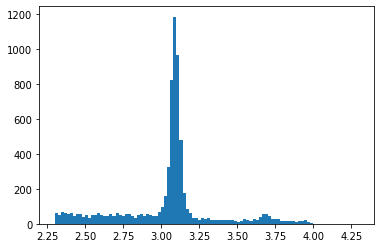

In [3]:
df.query("M > 2.3 and M < 4.3", inplace=True)
plt.hist(df.M, bins = np.linspace(2.3, 4.3, 101))
plt.show()

## Definition of the statistical model
In the following code block we define the statistical model composed of:
 * a Gaussian peak for the left peak ($J/\psi$),
 * a second Gaussian peak for the right peak ($\psi(2S)$), sharing the standard deviation with the former,
 * a background described by a decreasing exponential pdf.
 
The free parameters that we will adjust with a maximum likelihood fit are:
 * `m_j`, the central value of the $J/\psi$ peak
 * `m_psi`, the central value of the $\psi(2S)$ peak
 * `s` the standard deviation of the two peaks
 * `slope` is scale factor for the decreasing exponential describing the background
 * `n_j`, `n_psi` and `n_b` are the number of candidates under the $J/\psi$ peak, under the $\psi(2S)$ peak and constituting the background, respectively.
 
From a coding point of view, it is particularly convenient to include the definition of the loss function to minimize 
in the same class used to define the model, even if mathematically they represent two different objects and serve different purposes. 
In our case, we adopted an extended negative log likelihood as loss function.

In [4]:
class Model:
    def __init__ (self, x_data, range):
        self.m = x_data
        self.range = range
        
    def signal (self, m, m0, s):
        return 1./np.sqrt(2*np.pi*s**2) * np.exp (-0.5*((m-m0)/s)**2)
    
    def background (self, m, slope):
        return -np.exp(-m*slope)*slope/(np.exp(-slope*self.range[1]) - np.exp(-slope*self.range[0]))
    
    def pdf (self, m, m_j, m_psi, s, slope, n_j, n_psi, n_b):
        n = n_j + n_psi + n_b
        return n_j/n * self.signal(m, m_j, s) + n_psi/n * self.signal(m, m_psi, s) + n_b/n * self.background(m, slope)
    
    def nll (self, m_j, m_psi, s, slope, n_j, n_psi, n_b):
        n = n_j + n_psi + n_b
        return -np.sum(np.log(n*self.pdf(self.m, m_j, m_psi, s, slope, n_j, n_psi, n_b))) + n

### Testing the normalizations
The normalization of the single components, and of the model as a whole should be tested before fitting, as if the normalization is not 
guaranteed, the fit procedure may fail, or in worst case scenario could succeed converging towards a wrong minimum.

In [5]:
model = Model(df.M, range=(2.3, 4.3))

mAxis = np.linspace(2.3, 4.3, 1000)
print ("Signal normalization:", np.trapz(model.signal(mAxis, 3.1, 0.05), mAxis))
print ("Background normalization:", np.trapz(model.background(mAxis, 0.5), mAxis))

Signal normalization: 1.0
Background normalization: 1.0000000835002487


## Performing the fit 
We will use Minuit (interfaced to Jupyter with the `iminuit` package) to minimize the negative log likelihood and to estimate the uncertainty on the parameters at the minimum.

In [6]:
# Total number of candidates
n = len(df)

# Parameters in the same order as they appear in Model.nll:
#  m_j, m_psi, s, slope, n_j, n_psi, n_b
p0 = 3.1, 3.7, 0.025, 0.5, 0.4 * n, 0.03 * n, 0.57 * n

import iminuit
m = iminuit.Minuit(model.nll, *p0)
m.errordef = 0.5
m.migrad()
m.migrad()
p = np.array(m.values)
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.911e+04                 │              Nfcn = 241              │
│ EDM = 3.98e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m_j   │  3.0930   │  0.0005   │            │            │         │         │       │
│ 1 │ m_psi │   3.685   │   0.004   │            │            │         │         │       │
│ 2 │ s     │  29.7e-3  │  0.5e-3   │            │            │         │         │       │
│ 3 │ slope │   1.18    │   0.04    │            │            │         │         │       │
│ 4 │ n_j   │  4.03e3   │  0.07e3   │            │            │         │         │       │
│ 5 │ n_psi │    175    │    17     │            │            │         │         │       │
│ 6 │ n_b   │  2.93e3   │  0.06e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────────┐
│       │       m_j     m_psi         s     slope       n_j     n_psi       n_b │
├───────┼───────────────────────────────────────────────────────────────────────┤
│   m_j │  2.72e-07 -3.91e-09 -1.15e-08  9.46e-08 -0.000592 -6.25e-05  0.000592 │
│ m_psi │ -3.91e-09  1.37e-05  6.24e-08  2.98e-06   0.00139  0.000825  -0.00236 │
│     s │ -1.15e-08  6.24e-08  2.19e-07  1.75e-06    0.0047  0.000906  -0.00562 │
│ slope │  9.46e-08  2.98e-06  1.75e-06   0.00146     0.105     0.116    -0.229 │
│   n_j │ -0.000592   0.00139    0.0047     0.105  4.41e+03      33.4      -425 │
│ n_psi │ -6.25e-05  0.000825  0.000906     0.116      33.4       289      -145 │
│   n_b │  0.000592  -0.00236  -0.00562    -0.229      -425      -145   3.5e+03 │
└───────┴───────────────────────────────────────────────────────────────────────┘

## Graphical representation of the fit result
Finally, we represent the fit result by superposing the fitted model to the histogram.
We will also represent the statistical uncertainty on the event counts with error bars.

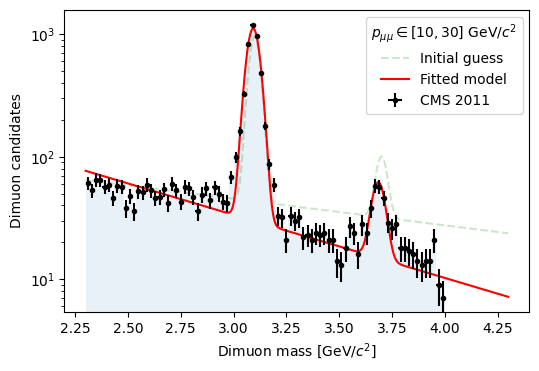

In [7]:
plt.figure(dpi=100)
bins = np.linspace(2.3, 4.3, 101)
plt.hist(df.M, bins=bins, alpha=0.1)
counts, _ = np.histogram(df.M, bins=bins)
centers = 0.5*(bins[:-1]+bins[1:])
plt.errorbar(centers, counts, np.sqrt(counts), 0.5*(bins[1]-bins[0]), 'k.', zorder=100, label="CMS 2011")
p0 = np.array(p0)
plt.plot(mAxis, model.pdf(mAxis, *p0)*p0[-3:].sum()*(bins[1]-bins[0]), 'g--', alpha=0.2, label="Initial guess" )
plt.plot(mAxis, model.pdf(mAxis, *p)*p[-3:].sum()*(bins[1]-bins[0]), color='red', label="Fitted model" )
plt.yscale('log')
plt.xlabel("Dimuon mass [GeV/$c^2$]")
plt.ylabel("Dimuon candidates")
plt.legend(title=f"$p_{{\mu\mu}} \in [{p_low}, {p_high}]$ GeV/$c^2$")
plt.show()

In [8]:
np.savez(output_filename,
         **dict(p_low=float(p_low), p_high=float(p_high)),
         **{k: v for k, v in m.values.to_dict().items()},
         **{'err_' + k: v for k, v in m.errors.to_dict().items()},
        )